# ***Importing libraries we need***

In [0]:
import numpy as np
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import keras
import glob
import cv2
from keras import backend as k
from keras.models import Sequential
from keras.layers import Conv2D ,Conv2DTranspose , Dropout , BatchNormalization , LeakyReLU , InputLayer
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from google.colab import drive
drive.mount('/content/drive')

Using TensorFlow backend.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ***Handling input and output Data for Training***

In [0]:
from scipy.misc import imresize 
from sklearn.preprocessing import normalize
import glob
from PIL import Image
from zipfile import ZipFile 
from io import BytesIO

def data_generator(data_path, labels_path):
  z_data =  ZipFile(data_path, 'r')
  z_labels =  ZipFile(labels_path, 'r')
  L_data = z_data.namelist()[45001:]
  L_labels = z_labels.namelist()[45001:]
  label_images = []   
  train_images = []
  for img_name, label_name in zip(L_data, L_labels):
    train_img = Image.open(BytesIO(z_data.read(img_name)))
    label_img = Image.open(BytesIO(z_labels.read(label_name)))
    train_images.append(np.expand_dims(imresize(np.array(train_img),(128,128)),axis=2))
    img = np.array(imresize(np.array(label_img),(128,128))) / 255
    label_images.append(img)
  
  return train_images , label_images  
    
train_path = '/content/drive/My Drive/data_b7b_elcima/gray.zip'
labels_path = '/content/drive/My Drive/data_b7b_elcima/colored.zip'
train_images , label_images = data_generator(train_path, labels_path)
'''
def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
        
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    #labels = batch['labels']
        
    return features
'''   
#label_images = []    
# Load training images
#train_images = []
'''
#imgs = load_cfar10_batch('/content/drive/My Drive/cifar-10-batches-py',1)
for c,path in enumerate (glob.glob('/content/drive/My Drive/train/*.jpg')):
  train_images.append(np.expand_dims(imresize(np.array(cv2.imread(path,0)),(128,128)),axis=2))
  #img = normalize(np.array(cv2.imread(path,1)).reshape((256*256*3,1)))
  img = np.array(imresize(np.array(cv2.imread(path,1)),(128,128))) / 255
  label_images.append(img)
'''
'''
for img in imgs:
  train_images.append(np.expand_dims(imresize(img[:,:,0],(128,128)),axis=2))
  img = normalize(img.reshape((3072,1)))
  label_images.append(imresize(img.reshape(32,32,3),(128,128)))
'''
# Make into arrays as the neural network wants these
images = np.array(train_images)
labels = np.array(label_images)
train_images.clear()
label_images.clear()
print(images.shape)
print(labels.shape)

# Validation set size 10% and remainder for training
X_train, X_val, y_train, y_val = train_test_split(images,labels, test_size=0.1)   
images = None
labels = None
#setting some parameters
batch_size = 128
epochs = 30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


# ***Building our model***

In [0]:
model = Sequential()
model.add(InputLayer(input_shape=(128,128,1)))
#encoder part
model.add(Conv2D(64,(4,4),padding='same',strides=(1,1),activation='relu',name='conv1'))
model.add(Conv2D(64,(4,4),padding='same',strides=(2,2),activation='relu',name='conv2'))
model.add(BatchNormalization())
model.add(Conv2D(128,(4,4),padding='same',strides=(2,2),activation='relu',name='conv3'))
model.add(BatchNormalization())
model.add(Conv2D(256,(4,4),padding='same',strides=(2,2),activation='relu',name='conv4'))
model.add(BatchNormalization())
model.add(Conv2D(512,(4,4),padding='same',strides=(2,2),activation='relu',name='conv5'))
model.add(BatchNormalization())
model.add(Conv2D(512,(4,4),padding='same',strides=(2,2),activation='relu',name='conv6'))
model.add(BatchNormalization())
model.add(Conv2D(512,(4,4),padding='same',strides=(2,2),activation='relu',name='conv7'))
model.add(BatchNormalization())
model.add(Conv2D(512,(4,4),padding='same',strides=(2,2),activation='relu',name='conv8'))
model.add(BatchNormalization())

#decoder part
model.add(Conv2DTranspose(512,(4,4),padding='same',strides=(2,2),name='deconv1'))
model.add(LeakyReLU(alpha=0.2))
model.add(Conv2DTranspose(512,(4,4),padding='same',strides=(2,2),name='deconv2'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.2))
model.add(Conv2DTranspose(512,(4,4),padding='same',strides=(2,2),name='deconv3'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.2))
model.add(Conv2DTranspose(256,(4,4),padding='same',strides=(2,2),name='deconv4'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.2))
model.add(Conv2DTranspose(128,(4,4),padding='same',strides=(2,2),name='deconv5'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.2))
model.add(Conv2DTranspose(64,(4,4),padding='same',strides=(2,2),name='deconv6'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.2))
model.add(Conv2DTranspose(64,(4,4),padding='same',strides=(2,2),name='deconv7'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.2))
#last layer
model.add(Conv2D(3,(4,4),padding='same',strides=(1,1),activation='sigmoid',name='last_layer'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 128, 128, 1)       4         
_________________________________________________________________
conv1 (Conv2D)               (None, 128, 128, 64)      1088      
_________________________________________________________________
conv2 (Conv2D)               (None, 64, 64, 64)        65600     
_________________________________________________________________
conv3 (Conv2D)               (None, 32, 32, 128)       131200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 128)       0         
_________________________________________________________________
conv4 (Conv2D)       

# ***Compiling model and train it***

In [0]:
from keras.models import load_model
# compile our model
model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['accuracy'])
ModelCheckpoint(filepath = '/content/drive/My Drive/movieColor.h5')
# training our model
model.fit_generator(ImageDataGenerator().flow(X_train, y_train, batch_size=batch_size),steps_per_epoch = len(X_train)/batch_size,validation_data = ImageDataGenerator().flow(X_val, y_val, batch_size=250) 
                    ,validation_steps = len(X_val)/16 ,epochs = epochs,verbose=2)
model.save("/content/drive/My Drive/movieColor.h5")

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
 - 131s - loss: 0.0452 - acc: 0.4270 - val_loss: 0.0359 - val_acc: 0.4814
Epoch 2/30
 - 110s - loss: 0.0370 - acc: 0.4606 - val_loss: 0.0341 - val_acc: 0.4879
Epoch 3/30
 - 110s - loss: 0.0351 - acc: 0.4576 - val_loss: 0.0312 - val_acc: 0.4939
Epoch 4/30
 - 110s - loss: 0.0341 - acc: 0.4672 - val_loss: 0.0336 - val_acc: 0.4964
Epoch 5/30
 - 110s - loss: 0.0333 - acc: 0.4746 - val_loss: 0.0305 - val_acc: 0.4906
Epoch 6/30
 - 110s - loss: 0.0326 - acc: 0.4776 - val_loss: 0.0314 - val_acc: 0.5045
Epoch 7/30
 - 110s - loss: 0.0321 - acc: 0.4775 - val_loss: 0.0321 - val_acc: 0.4971
Epoch 8/30


KeyboardInterrupt: ignored

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


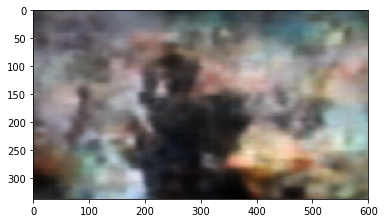

In [0]:
from scipy.misc import imsave
from keras.models import load_model
import cv2
import matplotlib.pyplot as plt

#load keras model
model = load_model('/content/drive/My Drive/movieColor.h5')
img = cv2.imread('/content/drive/My Drive/test.jpg',1)
lab_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
resizedImage = imresize(lab_image,(128,128))
resizedImage = np.expand_dims(resizedImage,axis=2)
lab_img = resizedImage[None,:,:,:]

# Output colorizations
output = model.predict(lab_img)
output = (output * 255)
# Re-size to match the original image
out_image = imresize(output[0], (338,600, 3))
plt.imshow(out_image)
#imsave("/content/drive/My Drive/img_result.png", cv2.cvtColor(out_image,cv2.COLOR_BGR2RGB))